<h1>Building a Neural network from scratch</h1>
<p>We are going to use just numpy for calculations with matrices and matplotlib.pyplot for showing results on charts</p>

In [44]:
import numpy as np
import matplotlib.pyplot as plt

<h4>ReLU:</h4>
<p>We use ReLU to set all the negative inputs to zero and leave positive inputs unchanged.<br>
It's simplicity makes it computationally efficient, especially in large neural networks.<br>
ReLU introduces non-linearity into the network, allowing it to learn complex patterns.<br>
For z > 0 the gradient is constant (dReLu(z)/dz =1), which help us avoid the vanishing gradient problem (which is common in sigmoid/tanh). <br>
Also it sets some activations to zero, which can help with computational efficiency and reduce the risk of overfitting.</p>

In [45]:
def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return Z > 0

<h4>Softmax Function:</h4>
<p>It converts raw scores z(logits) into probabilities and also ensures that the probabilities sum to 1 across all classes.<br>
Exponentiating the logits ensures all values are positive and also Larger logits get amplified more than smaller logits.<br>
Dividing by the sum of all exponentiated logits ensures the output values are probabilities is also some kind of normalization.The subtraction of max(Z) prevents numerical overflow(e.g for large exponentials).</p>
<p>In code below axis=0 ensures softmax is computed for each column(e.g for each class in a multi-class classification setting).<br>
And Also keepdims=True ensures that the result sum has the same dimensions as expZ, allowing for element-wise division without broadcasting issues.</p>
<h5>fromula for it is:</h5>

$$\text{softmax}(z_i) = \frac{\exp(z_i)}{\sum_{j=1}^{n} \exp(z_j)}$$


In [46]:
def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=0, keepdims=True))
    return expZ / np.sum(expZ, axis=0, keepdims=True)

<h4>Cross entropy loss function</h4>
<p>This function computes the cross-entropy loss, which measures the difference between the predicted probabilities (y_pred) and the true labels (y_true). It is commonly used in classification tasks, especially for multi-class classification with softmax outputs.</p>
<h5>fromula for this loss function is:</h5>

$$J = -\frac{1}{m} \sum_{i=1}^{m} \sum_{k=1}^{K} y_k^{(i)} \log(\hat{y}_k^{(i)})$$

If yk = 1(the correct class), the loss for that sample is equal to:

$$L = -\log(\hat{y}_k)$$
Encourages hat{yk} (the predicted probability for the correct class) to approach 1.<br>
The small value 1e-8 is added to hat{yk} to prevent taking the logarithm of 0, which would result in an undefined value

<h5>When Combined with Softmax Output:</h5>
<p>After simplifying, the gradient of the combined softmax and cross-entropy loss is:<br></p>

$$\frac{\partial z_k^{(i)}}{\partial J} = \hat{y}_k^{(i)} - y_k^{(i)}$$
<p>And when we Stack the derivatives for all m examples into a matrix: </p>

$$\frac{\partial Z}{\partial J} = \hat{Y} - Y$$


In [47]:
def cross_entropy_loss(y_true, y_pred):
    m = y_true.shape[1]
    loss = -np.sum(y_true * np.log(y_pred + 1e-8)) / m
    return loss

def cross_entropy_derivative(y_true, y_pred):
    return y_pred - y_true

<h4>Initializing the weights and biases</h4>
<p>Proper initialization of weights is critical for training the network effectively, as it impacts the convergence speed and overall performance.<br>
Poor initialization (e.g., very large or very small weights) can cause gradients to shrink (vanish) or grow (explode) exponentially as they propagate through layers.<br>
We set a seed for NumPy's random number generator to ensure reproducibility.<br>
Using the same seed produces the same random numbers every time the code runs, which is useful for debugging or comparing results.<br>
For initializing weights we use He initialization.<br>
For each weight we generate random values from a standard normal distribution(N(0, 1)) and scale it by * np.sqrt(2 / layer_dims[l-1])<br>
Using He initialization ensures the variance of the activations is maintained as the signal passes through layers, avoiding the problems of vanishing or exploding gradients<br></p>
<p>We initialize the biases to zeros by np.zeros()<br>
This doesn’t break symmetry, unlike initializing weights to zeros (which would cause all neurons in the layer to learn identical features).</p>



In [48]:
def initialize_parameters(layer_dims):
    np.random.seed(0)
    parameters = {}
    L = len(layer_dims)
    
    for l in range(1, L):
        parameters[f"W{l}"] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2 / layer_dims[l-1])
        parameters[f"b{l}"] = np.zeros((layer_dims[l], 1))
    return parameters

<h4>Dropout</h4>
<p>Dropout is a regularization technique where a random subset of neurons is "dropped" (set to 0) during training. This prevents the network from becoming too reliant on specific neurons and helps generalization.<br>
the process works like below:<br>
if dropout is enabled (keep_prob < 1.0):<br>
We create a random matrix D where each element is True with probability keep_prob and False otherwise.<br>
Then we drop some neurons in A by element-wise multiplying A and D and after that we scale the remaining activations by dividing by keep_prob.This will help us to maintain the expected value of the activations.After all, we store the dropout mask D in the cache.<br>
<h5>There are many benefits using this regularization technique:</h5>
<p>By randomly deactivating neurons, dropout prevents the network from relying too much on specific neurons.<br>
Also this technique forces the network to learn redundant representations since no single neuron can dominate.<br></p>


<h4>Forward propagation</h4>
<h5>In this function we calculates the outputs of each layer in the neural network from the input layer to the output layer.</h5>
<p>L is the total number of layers in the network (excluding the input layer). Each layer has weights and biases, hence parameters contains 2 * L keys.<br>
A is initially set to the input matrix X and cache is used to store intermediate values (activations A and pre-activations Z) for each layer, which will be needed during backward propagation.<br>
For each layer l we compute the pre-activation Z using the formula:<br>

$$Z^{[l]} = W^{[l]} \cdot A^{[l-1]} + b^{[l]}$$

where W[l] is the weight matrix for layer l.<br> A[l−1] is the activation from the previous layer (or input X for the first layer) <br>and b[l] is the bias vector for layer l.<br>
Then we compute the activation A using the ReLU activation function:
$$A^{[l]} = \text{ReLU}(Z^{[l]})$$
We also use Dropout Regularization the way we described above<br></p>
<p>in final layer:</p>
<p>we compute the pre-activation ZL for the final layer using the same formula as above.
then we compute the activation AL using the softmax function<br>
After all, We store the pre-activation ZL and activation AL for the final layer in the cache and Al will be our final output of the network</p>
<p>To put it in a nutshell:<br>
    We applie the weight and bias transformations(Z) layer-by-layer, starting from the input layer and moving toward the output layer.<br>
    Then we use non-linear activation functions (ReLU, softmax) to introduce non-linearity, allowing the network to model complex relationships.<br>
    Also we optionally use dropout to prevent overfitting by randomly deactivating neurons during training.<br>
    And in the end we store all intermediate values in cache, ensuring the data needed for backpropagation is available<br></p>

In [49]:
def forward_propagation(X, parameters, keep_prob=1.0):
    L = len(parameters) // 2
    A = X
    cache = {"A0": A}
    
    for l in range(1, L):
        Z = np.dot(parameters[f"W{l}"], A) + parameters[f"b{l}"]
        A = relu(Z)
        
        if keep_prob < 1.0:
            D = np.random.rand(A.shape[0], A.shape[1]) < keep_prob
            A = A * D
            A = A / keep_prob
            cache[f"D{l}"] = D
        
        cache[f"Z{l}"] = Z
        cache[f"A{l}"] = A

    ZL = np.dot(parameters[f"W{L}"], A) + parameters[f"b{L}"]
    AL = softmax(ZL)
    
    cache[f"Z{L}"] = ZL
    cache[f"A{L}"] = AL
    return AL, cache

<h4>L2 regularization</h4>
<h5>L2 regularization, also known as weight decay, is a technique used in machine learning to prevent overfitting by discouraging large weights in the model. It works by adding a penalty term to the cost function, which is proportional to the sum of the squared weights of the model. This encourages the model to keep the weights small, leading to a simpler and more generalizable model.</h5>
<p>Cost Function with L2 Regularization:<br>
The cost function J is modified to include a regularization term:

$$J_{\text{regularized}} = J_{\text{original}} + \frac{\lambda}{2m} \sum_{l=1}^{L} \|W^{[l]}\|_F^2$$

where J_originial is the original cost function(e.g. cross-entropy loss).<br>
λ is The regularization parameter that controls the strength of regularization.<br>
m is Number of training examples.<br>
and $$\|W^{[l]}\|_F^2$$ is The Frobenius norm (sum of squared elements) of the weight matrix W[l] for layer l.</p>
<p>Large weights in a model can lead to overfitting, as the model may memorize the training data instead of learning general patterns. L2 regularization discourages large weights.<br>
By penalizing large weights, L2 regularization encourages the model to rely on more features with small contributions rather than focusing heavily on a few.<br>
A model with smaller weights is often better at making predictions on unseen data.</p>
<p>Effect of λ on Regularization:<br>
Small λ:<br>
Weak regularization.<br>
The model is more likely to overfit, as the weights can grow large.<br>
Large λ:<br>
Strong regularization.<br>
The weights are heavily penalized, which can lead to underfitting, as the model may fail to capture important patterns.<br>
Tuning λ:<br>
λ is typically tuned using a validation set or cross-validation to find the right balance between underfitting and overfitting.<br></p>

<h4>Back propagation</h4>
<h5>In this function wecomputes the gradients of the cost function with respect to the parameters (W and 𝑏) of the network. These gradients are used during optimization (e.g gradient descent) to update the weights and biases.</h5>
<p>In our function :<br>
grads is A dictionary to store the gradients (dW and db) for each layer.<br>
m is The number of training examples (used to compute averages).<br>
and L is Total number of layers in the network.</p>
<p>Final layer computations:<br>
First, we retrieve Output Activations (AL):<br>
AL is the output of the softmax function in the last layer, stored in cache[f"A{L}"]<br>
we used L2 regularization as we described it above<br>
During backpropagation, the gradients of the cost function with respect to the weights are modified to include the derivative of the regularization term.<br>
Without Regularization:

$$dW^{[l]} = \frac{\partial J}{\partial W^{[l]}}$$
With L2 Regularization:

$$dW^{[l]} = \frac{\partial J_{\text{original}}}{\partial W^{[l]}} + \frac{\lambda}{m} W^{[l]}$$
the last term adds a penalty proportional to the weights, encouraging smaller values.<br>
Back to the operation in our function we Compute the Gradient of the Cost w.r.t. z[L]:
$$dZ^{[L]} = A^{[L]} - Y$$
This is derived from the derivative of the cross-entropy loss combined with the softmax activation function.<br>
Then we compute Gradients for Weights and Biases:<br>
For wieghts:<br>
$$dW^{[L]} = \frac{1}{m} \cdot dZ^{[L]} \cdot (A^{[L-1]})^\top + \frac{\lambda}{m} \cdot W^{[L]}$$
Which The first term computes the gradient of the loss w.r.t. the weights and the second term adds L2 regularization to prevent overfitting.<br>
for biases:<br>
$$db^{[l]} = \frac{1}{m} \sum_{i=1}^{m} dZ^{[l](i)}$$
We discussed about Dw in above , for db:<br>
We know For each training example i, the pre-activation Z [l] for a neuron is:<br>
$$Z^{[l](i)} = W^{[l]} \cdot A^{[l-1](i)} + b^{[l]}$$
The cost function J is typically a sum over all training examples:<br>
$$J = \frac{1}{m} \sum_{i=1}^{m} \text{Cost}^{(i)}$$
The gradient of the cost J w.r.t. the bias b[l] is:
$$\frac{\partial b^{[l]}}{\partial J} = \frac{1}{m} \sum_{i=1}^{m} \frac{\partial b^{[l]}}{\partial \text{Cost}^{(i)}}$$
For a single training example i, the cost depends on b[l] through z[l][i], so we use the chain rule:
$$\frac{\partial b^{[l]}}{\partial \text{Cost}^{(i)}} = \frac{\partial Z^{[l](i)}}{\partial \text{Cost}^{(i)}} \cdot \frac{\partial b^{[l]}}{\partial Z^{[l](i)}}$$
From the definition of z[l][i], the derivative w.r.t. b[l] is:
$$\frac{\partial b^{[l]}}{\partial Z^{[l](i)}} = 1$$
hence:
$$\frac{\partial b^{[l]}}{\partial \text{Cost}^{(i)}} = \frac{\partial Z^{[l](i)}}{\partial \text{Cost}^{(i)}} = dZ^{[l](i)}$$
Since b [l] is a vector (with one bias term for each neuron in the layer), this formula generalizes to:
$$db^{[l]} = \frac{1}{m} \sum_{i=1}^{m} dZ^{[l](i)}$$
<br>
Then back to our Back propagation aperation we loop Backward Through Each Layer and we compute dA[l]<br>
The gradient of the cost w.r.t. the activations of the current layer is computed using the chain rule:<br>

$$dA^{[l]} = W^{[l+1]^\top} \cdot dZ^{[l+1]}$$

We prove this in below:<br>
Using the chain rule, dA [l] can be expressed as:<br>
$$dA^{[l]} = \frac{\partial Z^{[l+1]}}{\partial J} \cdot \frac{\partial A^{[l]}}{\partial Z^{[l+1]}}$$
For computing second term we know The derivative of Z [l+1] with respect to A [l] is(based on the formula for z[l]):
$$\frac{\partial A^{[l]}}{\partial Z^{[l+1]}} = W^{[l+1]}$$
So we have :
$$dA^{[l]} = \frac{\partial Z^{[l+1]}}{\partial J} \cdot W^{[l+1]}$$
Using the notation:
$$dZ^{[l+1]} = \frac{\partial Z^{[l+1]}}{\partial J}$$
We rewrite:
$$dA^{[l]} = W^{[l+1]^\top} \cdot dZ^{[l+1]}$$
So this formula helps us propagates the error backward from the next layer.<br>
We can also apply Dropout if needed by reversing the effect of dropout by multiplying with the dropout mask (D) and scaling back with dividing by keep_prob.<br>
This ensures gradients flow only through the neurons that were active during the forward pass.<br>
For computing dz[l] we have the formula:
$$dZ^{[l]} = dA^{[l]} \cdot \text{ReLU}'(Z^{[l]})$$
Let's prove it:<br>
Using the chain rule:<br>
$$dZ^{[l]} = \frac{\partial Z^{[l]}}{\partial J} = \frac{\partial A^{[l]}}{\partial J} \cdot \frac{\partial Z^{[l]}}{\partial A^{[l]}}$$
We know the first term is equal to dA[l], the second term depends on the activation function which is ReLU(z[l]) in here so the final formulla for dz[l] is:
$$dZ^{[l]} = dA^{[l]} \cdot \text{ReLU}'(Z^{[l]})$$
Like the way we compute for the last layer we compute Gradients for Weights and Biases:<br>
For weights:<br>
$$dW^{[L]} = \frac{1}{m} \cdot dZ^{[L]} \cdot (A^{[L-1]})^\top + \frac{\lambda}{m} \cdot W^{[L]}$$
This is obviously true and be proved just like above by using chain rule so we won't cover it<br>
And for db the formulla is just like the one for the last layer<br>
At last, we store dW [l] and db [l] in the grads dictionary, and return the grads dictionary to use them to update weights and biases during optimization.</p>

In [50]:
def backward_propagation(X, Y, cache, parameters, keep_prob=1.0, lambda_=0.0):
    grads = {}
    m = X.shape[1]
    L = len(parameters) // 2

    AL = cache[f"A{L}"]
    dZL = cross_entropy_derivative(Y, AL)
    grads[f"dW{L}"] = (1 / m) * np.dot(dZL, cache[f"A{L-1}"].T) + (lambda_ / m) * parameters[f"W{L}"]
    grads[f"db{L}"] = (1 / m) * np.sum(dZL, axis=1, keepdims=True)

    for l in reversed(range(1, L)):
        dA = np.dot(parameters[f"W{l+1}"].T, dZL)

        if keep_prob < 1.0:
            dA = dA * cache[f"D{l}"]
            dA = dA / keep_prob

        dZL = dA * relu_derivative(cache[f"Z{l}"])
        grads[f"dW{l}"] = (1 / m) * np.dot(dZL, cache[f"A{l-1}"].T) + (lambda_ / m) * parameters[f"W{l}"]
        grads[f"db{l}"] = (1 / m) * np.sum(dZL, axis=1, keepdims=True)
    
    return grads

<h4>Updating parameter</h4>
<p> function is responsible for adjusting the weights and biases of a neural network using the gradients computed during backpropagation. This adjustment ensures that the model's predictions get closer to the true labels, thereby reducing the cost function J over time.<br>
The function is an implementation of gradient descent<br>
During backpropagation, the gradients 

$$\frac{\partial W^{[l]}}{\partial J},\frac{\partial b^{[l]}}{\partial J}$$
are computed for each layer. These gradients tell us how much W[l] and b [l]need to change to reduce J.<br>
Gradient descent updates the parameters by taking a step in the direction opposite to the gradient:<br>
$$\theta = \theta - \alpha \cdot \nabla_\theta J$$
where:<br>
θ represents the parameters (W [l], b [l]).<br>
∇_θJ represents the gradient of J with respect to θ.<br>
α is the learning rate, controlling the step size.<br>
<br>
The gradient ∇_θJ indicates the direction of the steepest increase in J. Moving in the opposite direction reduces J.
A small learning rate ensures stable convergence but slows down training.<br>
A large learning rate speeds up training but risks overshooting the minimum.<br>
Each update reduces J, and the process is repeated over many iterations (epochs) to converge to a minimum.<br>
<br>
In our function we update the weights by:<br>

$$W^{[l]} = W^{[l]} - \alpha \cdot dW^{[l]}$$
where:<br>
α: Learning rate.<br>
dW[l] : Indicates the direction and magnitude of change required for W[l] to minimize the cost function J.<br>
And for biases:<br>
$$b^{[l]} = b^{[l]} - \alpha \cdot db^{[l]}$$
where:<br>
α: Learning rate.<br>
db[l] : Indicates the direction and magnitude of change required for b[l] to minimize the cost function J.<br>

In [51]:
def update_parameters(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(1, L + 1):
        parameters[f"W{l}"] -= learning_rate * grads[f"dW{l}"]
        parameters[f"b{l}"] -= learning_rate * grads[f"db{l}"]
    return parameters

<h4>creating mini batches</h4>
<h5>This function divides the training data into smaller subsets (mini-batches) for training. Mini-batches improve training efficiency and stability.</h5>
<p>First, we shuffle the Data and randomize the order of the training examples by generating a random permutation of indices.<br>
This will ensures that mini-batches contain different subsets of data in each epoch.<br>
Then we split our Data into Mini-Batches,which means we Creates subsets of X and Y for each mini-batch<br>
After all, We handle Leftover Examples:<br>
If the total number of examples (m) is not divisible by the mini-batch size, it creates a smaller batch with the remaining examples.<br></p>

In [52]:
def create_mini_batches(X, Y, mini_batch_size):
    m = X.shape[1]
    mini_batches = []
    permutation = np.random.permutation(m)
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    num_complete_minibatches = m // mini_batch_size
    for k in range(num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size:(k + 1) * mini_batch_size]
        mini_batches.append((mini_batch_X, mini_batch_Y))

    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size:]
        mini_batches.append((mini_batch_X, mini_batch_Y))

    return mini_batches

<h4>Training the model</h4>
<h5>This is the main function that trains the neural network by iterating through the training data, performing forward propagation, backpropagation, and updating the weights and biases.</h5>
<p>First, we call initialize_parameters(layer_dims) to initialize weights and biases for the network.<br>
Then, we loop through a specified number of epochs (iterations over the full dataset).<br>
For each epoch we:<br>
Reduce the learning rate as the epochs progress.<br>
Then, we call create_mini_batches to split the training data into smaller batches and shuffles them every time.<br>
For each mini-batch we do:<br>
Forward Propagation:to compute activations and stores intermediate values.<br>
Backward Propagation:to compute gradients using the cost function.<br>
Update Parameters:to adjust weights and biases using gradients.<br>
After that, we compute loss (using cross_entropy_loss) and test accuracy at the end of each epoch and we print the loss and accuracy periodically.<br>
In the end, we plot loss and accuracy trends over epochs.<br>

In [53]:
def plot_metrics(losses, accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(accuracies)
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.show()

In [54]:
def train_model(X_train, Y_train, X_test, Y_test, layer_dims, epochs, learning_rate, mini_batch_size, keep_prob, lambda_, decay_rate):
    parameters = initialize_parameters(layer_dims)
    m = X_train.shape[1]
    losses = []
    accuracies = []

    for epoch in range(epochs):
        learning_rate_epoch = learning_rate / (1 + decay_rate * epoch)
        mini_batches = create_mini_batches(X_train, Y_train, mini_batch_size)

        for mini_batch in mini_batches:
            (mini_batch_X, mini_batch_Y) = mini_batch
            
            AL, cache = forward_propagation(mini_batch_X, parameters, keep_prob)
            grads = backward_propagation(mini_batch_X, mini_batch_Y, cache, parameters, keep_prob, lambda_)
            parameters = update_parameters(parameters, grads, learning_rate_epoch)

        AL_train, _ = forward_propagation(X_train, parameters)
        loss = cross_entropy_loss(Y_train, AL_train)
        losses.append(loss)

        AL_test, _ = forward_propagation(X_test, parameters)
        predictions = np.argmax(AL_test, axis=0)
        labels = np.argmax(Y_test, axis=0)
        accuracy = np.mean(predictions == labels)
        accuracies.append(accuracy)

        if epoch % 10 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}, Loss: {loss:.4f}, Test Accuracy: {accuracy * 100:.2f}%")

    plot_metrics(losses, accuracies)
    return parameters

<h4>One-Hot Encoded Matrix<h4>
<p>we need a function to make One-Hot Encoded Matrix from our data where each column corresponds to one training example, and each row corresponds to a class.<br>
Neural networks output probabilities for each class (e.g., softmax). One-hot encoding aligns the target labels with this format.<br>
Cross-entropy loss can directly compare the predicted probabilities to the one-hot encoded labels.<br>
First we initialize a One-Hot Matrix:<br>
np.zeros((num_classes, m)) creates a matrix of zeros with:<br>
num_classes: Number of possible output classes (for our network 10 for digits 0–9).<br>
m: Number of examples in the dataset.<br>
Ten we encode Labels:<br>
labels: An array of shape (m,) containing the actual class labels for each example.<br>
one_hot[labels, np.arange(m)] = 1:<br>
For each example i, it sets the value at one_hot[labels[i], i] to 1.<br>
This effectively "activates" the correct class for each example in the one-hot matrix.<br>
After that, We return the One-Hot Encoded Matrix:<br>
The resulting matrix has shape (num_classes, m), where each column corresponds to one training example, and each row corresponds to a class.</p>


In [55]:
def one_hot_encode(labels, num_classes):
    m = labels.shape[0]
    one_hot = np.zeros((num_classes, m))
    one_hot[labels, np.arange(m)] = 1
    return one_hot

<h4>Loading Data from our Dataset</h4>
<p>We need a function to load the Dataset:<br>
The MNIST dataset is stored in a compressed file (mnist.npz).<br>
np.load("mnist.npz"): Loads the dataset as a dictionary-like object where the keys ("x_train", "y_train", "x_test", "y_test") correspond to training/test features and labels.<br>
The MNIST data consists of grayscale images of digits (28x28 pixels). These are converted into 1D vectors (flattened) and normalized to the range [0, 1].<br>
Steps:<br>
reshape(X_train.shape[0], -1): Flattens each 28x28 image into a vector of 784 values (28x28 = 784).<br>
.T: Transposes the dataset so each column corresponds to one training example.<br>
dividing by 255.0: Normalizes the pixel values (originally in [0, 255]) to [0, 1].<br>
One-Hot Encodes the Labels:<br>
Calls the one_hot_encode function to convert the labels (0–9) into a one-hot encoded format.<br>
This ensures the labels can be used for multi-class classification (e.g., softmax).<br>
Returns Preprocessed Data:<br>
Outputs the preprocessed training and test features (X_train, X_test) and their corresponding one-hot encoded labels (Y_train, Y_test).<br>

In [56]:
def load_data():
    with np.load("mnist.npz") as data:
        X_train, Y_train = data["x_train"], data["y_train"]
        X_test, Y_test = data["x_test"], data["y_test"]

    X_train = X_train.reshape(X_train.shape[0], -1).T / 255.0
    X_test = X_test.reshape(X_test.shape[0], -1).T / 255.0
    Y_train = one_hot_encode(Y_train, 10)
    Y_test = one_hot_encode(Y_test, 10)

    return X_train, Y_train, X_test, Y_test

<h4>Test</h4>
<p>We use x_test as input of our network, Forward propaganate it and compare the results(the class with highest probability) we get with the true labels(y_test) to check our accuracy</p>

In [57]:
def test_model(X_test, Y_test, parameters):
    A2_test, _ = forward_propagation(X_test, parameters)

    predictions = np.argmax(A2_test, axis=0) 
    labels = np.argmax(Y_test, axis=0) 
    
    accuracy = np.mean(predictions == labels)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")
    
    return predictions

<h4>Running the Code!</h4>
<p>in this last section we daclare the layer dims, number of epochs, initial learning_rate, mini_batch_size,keep_prob for dropout regularization,lambda for L2 regularization and decay rate for updating the learning rate for each epoch, we need to set them carefully so our network won't be facing with overfitting or underfitting problems and gets the best accuracy<br>
We load the data set and train our model and test it in this function<br>
<br>
For setting layer dims correctly:<br>
Input Layer:<br>
The number of neurons in the input layer should match the number of features (784 for MNIST).<br>
If Incorrect: The network won't align with the input data dimensions, causing dimensional mismatches and runtime errors.<br>
Hidden Layers:<br>
Typically, hidden layers have fewer neurons than the input layer.<br>
Fewer neurons make the network smaller and faster but risk underfitting.<br>
Too many neurons increase computational cost and risk overfitting.<br>
Output Layer:<br>
The number of neurons in the output layer must match the number of classes (10 for MNIST).<br>
If Incorrect: The model won’t output probabilities for all classes, making it impossible to calculate the loss or predict correctly.<br>
<br>
Setting the number of epoches:<br>
Epoches number is the number of times the entire training dataset is passed through the network.<br>
Too Few: The model might not fully learn the patterns in the data (underfitting).<br>
Too Many: The model might overfit, learning the noise in the training data.<br>
<br>
Setting the number of learning_rate:<br>
Controls the step size of gradient descent.<br>
Too Small: Training will be slow or might get stuck in local minima.<br>
Too Large: The model might overshoot the minimum of the cost function and fail to converge.<br>
<br>
Setting the mini_batch_size:<br>
The size of each mini-batch used for training.<br>
Too Small: Increases training time (more updates per epoch).<br>
Too Large: Reduces the stochastic nature of gradient descent, leading to poor generalization.<br>
<br>
Setting the keep_prob:<br>
Dropout probability (used to prevent overfitting).<br>
Higher Values(e.g. 0.9): Less regularization, risking overfitting.<br>
Lower Values(e.g. 0.5): Too much regularization, risking underfitting.<br>
<br>
Setting the lambda:<br>
Regularization strength (L2 regularization).<br>
Higher Values(e.g. 0.1): Stronger regularization, discouraging large weights but risking underfitting.<br>
Lower Values(e.g. 0.001): Weaker regularization, risking overfitting.<br>
<br>
Setting the decay_rate:<br>
Decay factor for the learning rate and Gradually decreases the learning rate over time to help fine-tune the model toward the end of training.<br>
Too High: The learning rate drops too quickly, preventing the model from learning effectively.<br>
Too Low: The learning rate doesn’t drop enough, leading to overshooting or slower convergence.<br>
</p>


Epoch 0, Loss: 0.4166, Test Accuracy: 89.04%
Epoch 10, Loss: 0.1172, Test Accuracy: 96.05%
Epoch 20, Loss: 0.0717, Test Accuracy: 97.10%
Epoch 30, Loss: 0.0480, Test Accuracy: 97.57%
Epoch 40, Loss: 0.0347, Test Accuracy: 97.77%
Epoch 50, Loss: 0.0251, Test Accuracy: 97.99%
Epoch 60, Loss: 0.0194, Test Accuracy: 98.06%
Epoch 70, Loss: 0.0143, Test Accuracy: 98.12%
Epoch 80, Loss: 0.0110, Test Accuracy: 98.15%
Epoch 90, Loss: 0.0086, Test Accuracy: 98.16%
Epoch 99, Loss: 0.0070, Test Accuracy: 98.20%


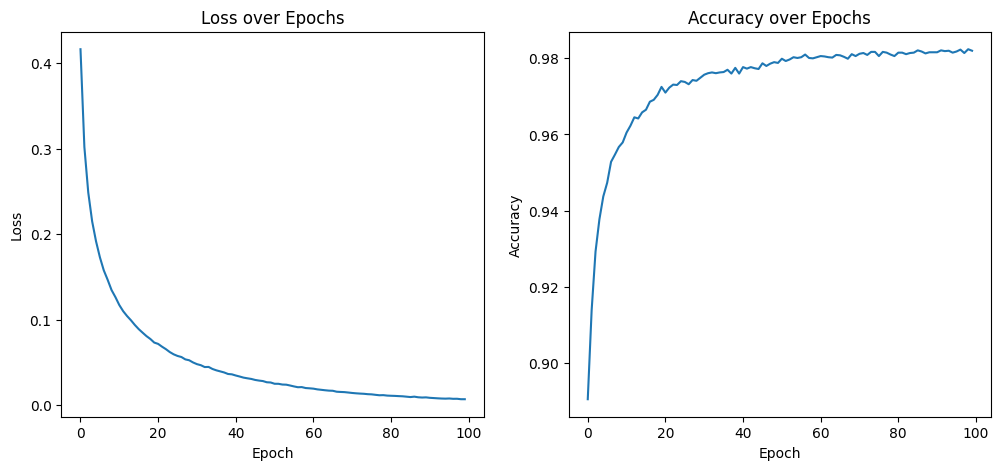

Test Accuracy: 98.20%


In [58]:
def main():
    X_train, Y_train, X_test, Y_test = load_data()
    layer_dims = [784, 256, 128, 64, 10]  # Input, three hidden layers, output
    parameters = train_model(
        X_train, Y_train, X_test, Y_test,
        layer_dims=layer_dims,
        epochs=100,
        learning_rate=0.01,
        mini_batch_size=64,
        keep_prob=0.8,
        lambda_=0.01,
        decay_rate=0.001
    )

    test_model(X_test, Y_test, parameters)

main()